In [12]:
import math

import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
stemmer = PorterStemmer()

In [4]:
tdf_g = pd.read_csv('working-csvs/speaker_grouped_trimmed.csv', index_col=0)

In [5]:
tdf_g

,date,speaker,text_enhanced
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin..."
1697,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S..."
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development..."
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...
1700,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i..."
...,...,...,...
6827,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...
6828,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla..."
6829,2017-12-13,MS. LOGAN.,Thank you. I will begin on your second exhibi...
6830,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from..."


In [6]:
tdf_g['tokens'] = tdf_g['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [7]:
texts = tdf_g['tokens'].tolist()

In [8]:
dictionary = Dictionary().load('12-10dict')

In [9]:
len(dictionary)

10957

In [10]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
K = 45

In [12]:
ldamodel = LdaModel(corpus, num_topics=K, id2word=dictionary, passes=10, random_state=0, minimum_probability=0, eta=0.025, alpha=50/K)

In [ ]:
# ldamodel.save('12-10lda')


In [4]:
ldamodel = LdaModel.load('models/12-10lda')

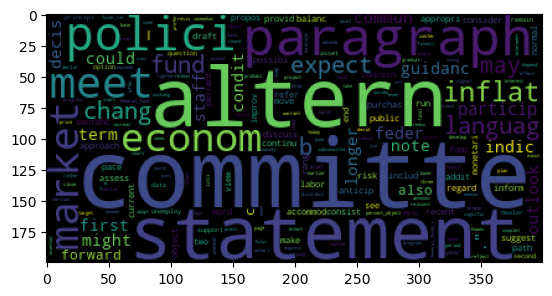

In [9]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(42, 200))))

In [ ]:
ldamodel.print_topics(num_topics=45, num_words=12)

In [6]:
ldamodel.show_topic(0, topn=12)

[('tax', 0.03586149),
 ('fiscal', 0.026546545),
 ('year', 0.014743081),
 ('polici', 0.009564014),
 ('percent', 0.009538713),
 ('move', 0.008503707),
 ('congress', 0.008355867),
 ('govern', 0.00826546),
 ('get', 0.0073290574),
 ('cut', 0.007179166),
 ('elect', 0.006963833),
 ('effect', 0.006916636)]

In [36]:
wordprobs = np.array([[round(prob,2) for word, prob in ldamodel.show_topic(i, topn=12)] for i in range(45)])
words = np.array([[word for word, prob in ldamodel.show_topic(i, topn=12)] for i in range(45)])

In [17]:
topic_labels = [f'Topic {i}' for i in range(45)]

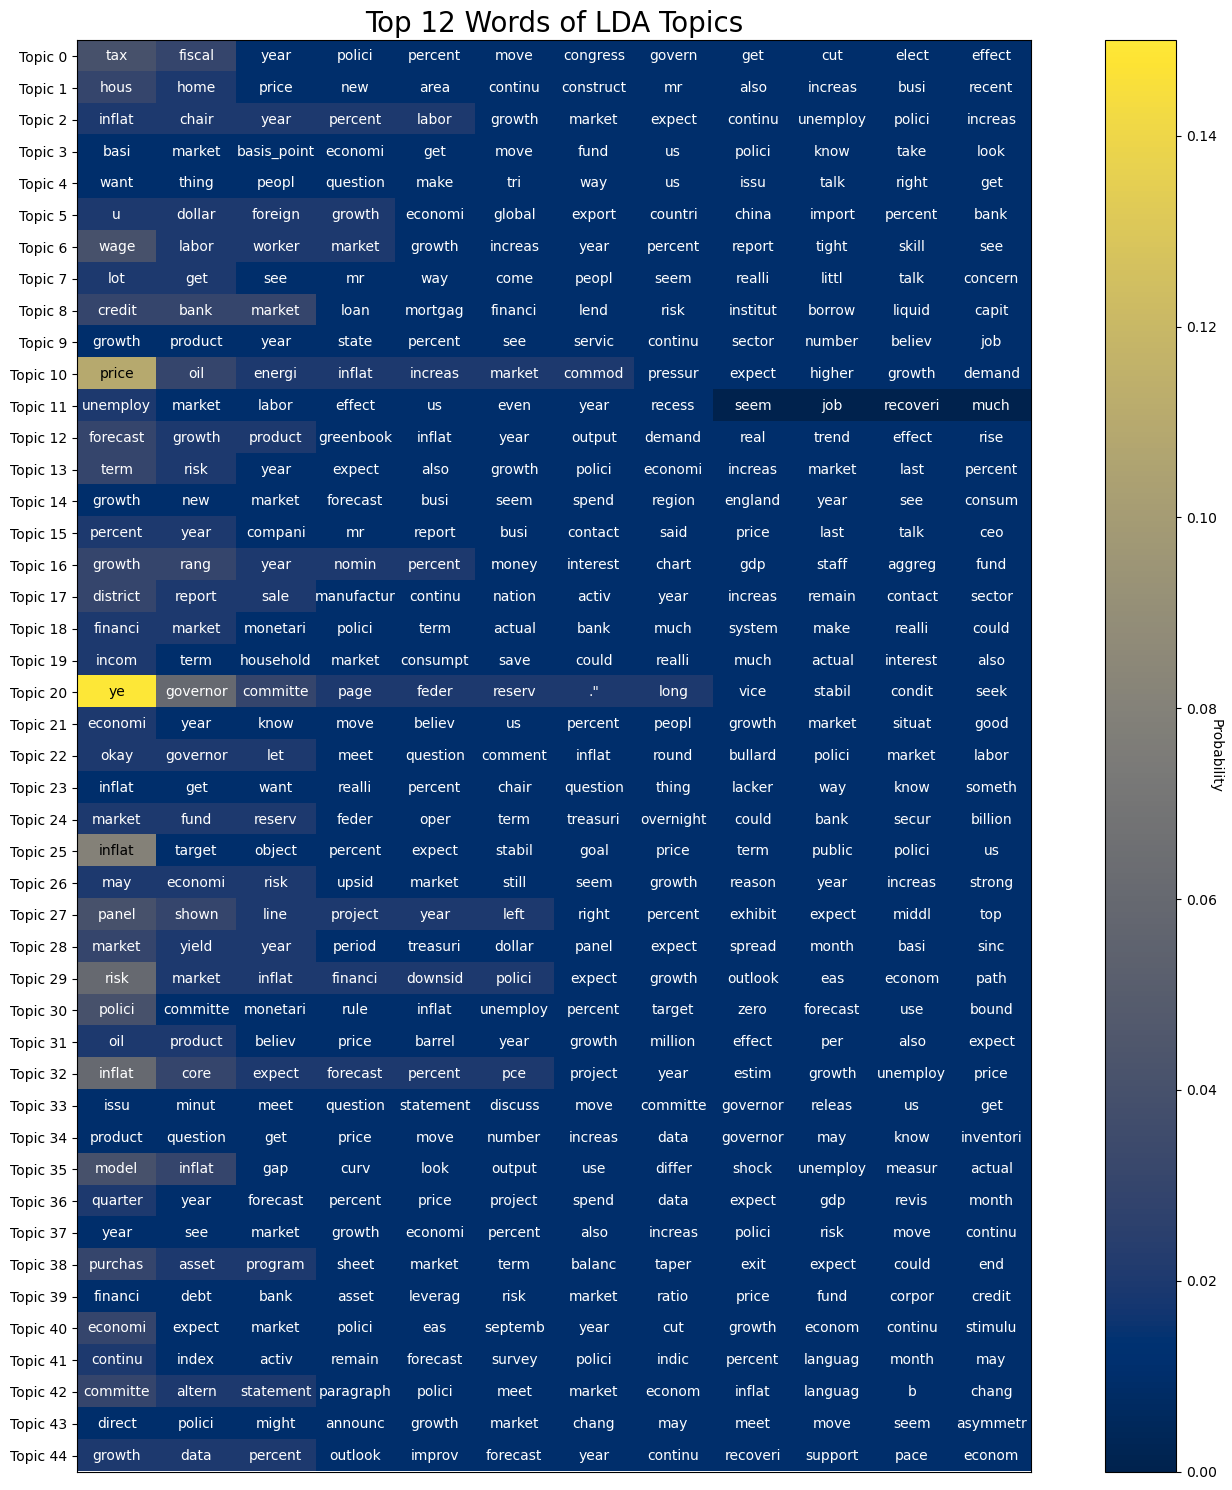

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(wordprobs, aspect='0.4', cmap='cividis')

ax.set_title('Top 12 Words of LDA Topics', fontsize=20 )

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Probability', rotation=-90)

ax.set_yticks(np.arange(45), labels=topic_labels)
ax.set_xticks([])

textcolors=('white', 'black')

for i in range(45):
    for j in range(12):
        text = ax.text(j, i, words[i, j], ha='center', va='center', color=textcolors[int(im.norm(wordprobs[i,j]) > 0.4)])

fig.tight_layout()

print()

In [17]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * 45
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [18]:
tdf_g[[f'tprob_{i}' for i in range(45)]] = tdf_g.tokens.apply(get_all_topics)

In [ ]:
tdf_g

In [ ]:
tdf_g['tokens']

EVENTUALLY FIX THIS TO ONLY INCLUDE WORDS NOT PRUNED BY TF-IDF

In [19]:
tdf_g['len'] = tdf_g['tokens'].apply(len)

In [20]:
tdf_g.to_csv('working-csvs/grouped_w_topics.csv')